In [1]:
import math
from collections import defaultdict

import networkx as nx
import pandas as pd

articles_file_path = "data/wikispeedia/wikispeedia_paths-and-graph/articles.tsv"
paths_file_path = "data/wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv"
links_file_path = "data/wikispeedia/wikispeedia_paths-and-graph/links.tsv"
alpha = 1 / 5

In [2]:
# Read articles
tsv_content = ""
with open(articles_file_path, "r") as f:
    tsv_content = f.read()

lines = tsv_content.strip().split("\n")
articles = []
for line in lines:
    if not line or line.strip().startswith("#"):
        continue
    articles.append(line)

In [3]:
# Read finished paths 
tsv_content = ""
with open(paths_file_path, "r") as f:
    tsv_content = f.read()

lines = tsv_content.strip().split("\n")

# List to store the final processed lists from the fourth column
processed_paths = []
for line in lines:
    if not line or line.strip().startswith("#"):
        continue  # Skip empty lines and comments
    columns = line.split("\t")
    if len(columns) >= 4:
        items = columns[3].split(";") # Get the "path" column
        processed_path = []
        for item in items:
            if item == "<":
                processed_path.pop()
            else:
                processed_path.append(item)
        processed_paths.append(processed_path)

print(f"{len(processed_paths)} paths processed.")

51318 paths processed.


In [4]:
# Calculate N(A, G)
N_precalc = defaultdict(int)
for path in processed_paths:
    goal = path[-1]
    for i in range(len(path) - 1):
        N_precalc[(path[i], goal)] += 1

# Calculate N(A', A, G)
N_prime_precalc = defaultdict(int)
for path in processed_paths:
    goal = path[-1]
    for i in range(len(path) - 1):
        N_prime_precalc[(path[i + 1], path[i], goal)] += 1

In [5]:
# Calc outlinks
tsv_content = ""
with open(links_file_path, "r") as f:
    tsv_content = f.read()

lines = tsv_content.strip().split("\n")

outlinks = {article: set() for article in articles}
for line in lines:
    if not line or line.strip().startswith("#"):
        continue  # Skip empty lines and comments
    columns = line.split("\t")
    outlinks[columns[0]].add(columns[1])

L_a = {key: len(value) for key, value in outlinks.items()}

In [6]:
# Calc pagerank
graph = nx.graph.Graph()

# Add edges from the adjacency list
for node, neighbors in outlinks.items():
    if not node in graph.nodes:
        graph.add_node(node)
    for neighbor in neighbors:
        graph.add_edge(node, neighbor)

pageranks = nx.pagerank(graph)

In [7]:
# Calc d_p
def P_star(A_prime, A, G):
    return (N_prime_precalc.get((A_prime, A, G), 0) + alpha) / (
        N_precalc.get((A, G), 0) + alpha * L_a[A]
    )


dp = defaultdict(list)
for path in processed_paths:
    goal = path[-1]
    for i in range(len(path) - 1):
        dp[(path[i], goal)].append(
            sum(
                [
                    math.log2(P_star(path[j + 1], path[j], goal))
                    for j in range(i, len(path) - 1)
                ]
            )
            / math.log2(pageranks[goal])
        )

In [8]:
d = {key: sum(value) / len(value) for key, value in dp.items()}

In [ ]:
# Some manual tests
tests = [
    ("Minneapolis%2C_Minnesota", "Minnesota"),
    ("Minnesota", "Minneapolis%2C_Minnesota"),
    ("Linguistics", "Noam_Chomsky"),
    ("Language", "Noam_Chomsky"),
    ("Music", "Noam_Chomsky"),
    ("Television", "Noam_Chomsky"),
    ("Education_in_the_United_States", "Noam_Chomsky"),
]

# Some tests for articles like (a, b) for which we have the distance of (a, b) and (b, a)
for a, b in d.keys():
    if (b, a) in d.keys():
        tests.append((a, b))
        tests.append((b, a))

tests = pd.DataFrame(tests, columns=["a", "b"])
tests["distance"] = tests[["a", "b"]].apply(lambda x: d[(x["a"], x["b"])], axis=1)
tests.to_csv("distances.csv")

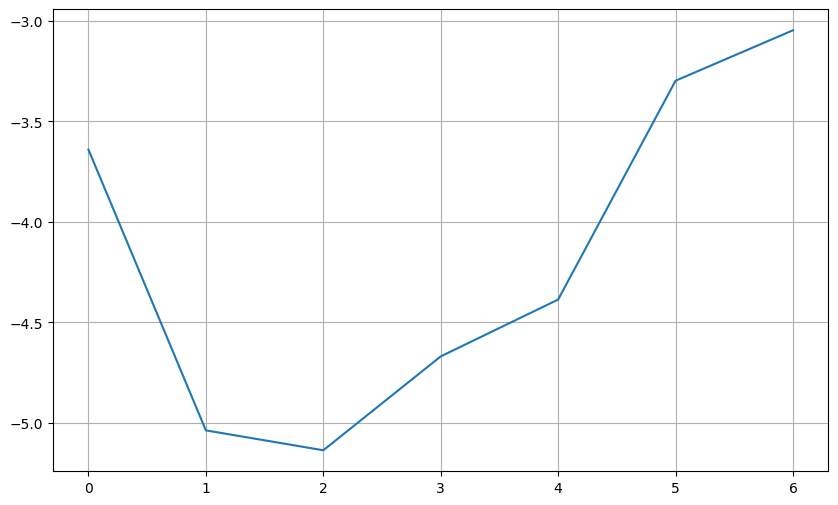

In [ ]:
# Calculate information gain for each step in paths as proposed by the article(Probably not working properly)
inf_gain_list = []
for _ in range(7):
    inf_gain_list.append([])

for path in processed_paths[0:1600]:
    for i in range(len(path) - 1):
        A = path[i]
        A_prime = path[i + 1]
        G = path[-1]

        # Calculate probabilities
        p_star = P_star(A_prime, A, G)
        H0 = -(1 / L_a[A]) * math.log2(1 / L_a[A]) if L_a[A] > 0 else 0
        H_star = -sum(
            [
                P_star(A_next, A, G) * math.log2(P_star(A_next, A, G))
                for A_next in outlinks[A]
            ]
        )

        # Calculate information gain
        information_gain = H0 - H_star

        if i / (len(path) - 1) <= (1 / 7):
            inf_gain_list[0].append(information_gain)
        elif i / (len(path) - 1) <= (2 / 7):
            inf_gain_list[1].append(information_gain)
        elif i / (len(path) - 1) <= (3 / 7):
            inf_gain_list[2].append(information_gain)
        elif i / (len(path) - 1) <= (4 / 7):
            inf_gain_list[3].append(information_gain)
        elif i / (len(path) - 1) <= (5 / 7):
            inf_gain_list[4].append(information_gain)
        elif i / (len(path) - 1) <= (6 / 7):
            inf_gain_list[5].append(information_gain)
        elif i / (len(path) - 1) <= (7 / 7):
            inf_gain_list[6].append(information_gain)

import matplotlib.pyplot as plt

avg_inf_gain = []
for i, l in enumerate(inf_gain_list):
    avg_inf_gain.append([])
    avg_inf_gain[i] = sum(l) / len(l)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_inf_gain)
plt.grid(True)
plt.show()